# Data Analysis Tools
# Assignment: Running an analysis of variance

Following is the Python program I wrote to fulfill the first assignment of the [Data Analysis Tools online course](https://www.coursera.org/learn/data-analysis-tools/home/welcome).

I decided to use [Jupyter Notebook](http://nbviewer.jupyter.org/github/ipython/ipython/blob/3.x/examples/Notebook/Index.ipynb) as it is a pretty way to write code and present results.

## Research question

Using the [Gapminder database](http://www.gapminder.org/), I would like to see if an increasing Internet usage results in an increasing suicide rate. A study shows that other factors like unemployment could have a great impact.

So for this assignment, the three following variables will be analyzed:

- Internet Usage Rate (per 100 people)
- Suicide Rate (per 100 000 people)
- Unemployment Rate (% of the population of age 15+)


## Data management

For the question I'm interested in, the countries for which data are missing will be discarded. As missing data in Gapminder database are replace directly by `NaN` no special data treatment is needed.

In [1]:
# Magic command to insert the graph directly in the notebook
%matplotlib inline
# Load a useful Python libraries for handling data
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

In [2]:
# Read the data
data_filename = r'gapminder.csv'
data = pd.read_csv(data_filename, low_memory=False)
data = data.set_index('country')

General information on the Gapminder data

In [3]:
display(Markdown("Number of countries: {}".format(len(data))))
display(Markdown("Number of variables: {}".format(len(data.columns))))

Number of countries: 213

Number of variables: 15

In [4]:
# Convert interesting variables in numeric format
for variable in ('internetuserate', 'suicideper100th', 'employrate'):
    data[variable] = pd.to_numeric(data[variable], errors='coerce')


But the unemployment rate is not provided directly. In the database, the employment rate (% of the popluation) is available. So the unemployement rate will be computed as `100 - employment rate`:

In [5]:
data['unemployrate'] = 100. - data['employrate']

The first records of the data restricted to the three analyzed variables are:

In [6]:
subdata = data[['internetuserate', 'suicideper100th', 'unemployrate']]
subdata.head(10)

,internetuserate,suicideper100th,unemployrate
country,,,
Afghanistan,3.654122,6.684385,44.299999
Albania,44.989947,7.699330,48.599998
Algeria,12.500073,4.848770,49.500000
Andorra,81.000000,5.362179,NaN
Angola,9.999954,14.554677,24.300003
Antigua and Barbuda,80.645455,2.161843,NaN
Argentina,36.000335,7.765584,41.599998
Armenia,44.001025,3.741588,59.900002
Aruba,41.800889,NaN,NaN


## Data analysis

The distribution of the three variables have been analyzed [previously](Visualizing_Data.ipynb).



## Variance analysis

Now that the univariate distribution as be plotted and described, the bivariate graphics will be plotted in order to test our research hypothesis.

Let's first focus on the primary research question;

- The explanatory variable is the internet use rate (quantitative variable)
- The response variable is the suicide per 100,000 people (quantitative variable)

From the scatter plot, a slope slightly positive has been seen. And as most of the countries have no or very low internet use rate, an effect is maybe seen only on the countries having the higher internet use rate. 

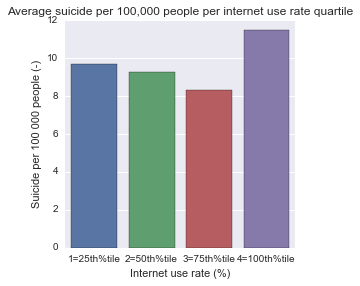

In [7]:
subdata2 = subdata.assign(internet_grp4 = pd.qcut(subdata.internetuserate, 4, 
                                       labels=["1=25th%tile", "2=50th%tile", 
                                               "3=75th%tile", "4=100th%tile"]))
sns.factorplot(x='internet_grp4', y='suicideper100th', data=subdata2, 
               kind="bar", ci=None)
plt.xlabel('Internet use rate (%)')
plt.ylabel('Suicide per 100 000 people (-)')
_ = plt.title('Average suicide per 100,000 people per internet use rate quartile')

This case falls under the Categorical to Quantitative case of interest for this assignement. So ANOVA analysis can be performed here.


- The null hypothesis is: There is no relationship between the Internet use rate and suicide
- The alternate hypothesis is: There is a relationship between the Internet use rate and suicide

In [8]:
model1 = smf.ols(formula='suicideper100th ~ C(internet_grp4)', data=subdata2).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        suicideper100th   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.834
Date:                Sat, 21 May 2016   Prob (F-statistic):              0.143
Time:                        15:50:19   Log-Likelihood:                -573.25
No. Observations:                 177   AIC:                             1155.
Df Residuals:                     173   BIC:                             1167.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
Intercept                            9.6848      0.910     10.638      0.000         7.888    11.482
C(internet_grp4)[T.2=50th%tile]     -0.3902      1.281     -0.305      0.761        -2.918     2.138
C(internet_grp4)[T.3=75th%tile]     -1.3509      1.317     -1.026      0.306        -3.951     1.249
C(internet_grp4)[T.4=100th%tile]     1.8173      1.352      1.344      0.181        -0.851     4.486
==============================================================================
Omnibus:                       55.631   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.033
Skew:                           1.431   Prob(JB):                     8.61e-27
Kurtosis:                       5.844   Cond. No.                         4.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value found is 0.143 > 0.05. Therefore the null hypothesis cannot be rejected. There is no relationship between the internet use rate and the suicide rate.

## Test case to fulfill the assignment

In order to fulfill the assignment, I will switch to the NESARC database.

In [9]:
nesarc = pd.read_csv('nesarc_pds.csv', low_memory=False)

In [10]:
races = {1 : 'White', 
         2 : 'Black', 
         3 : 'American India/Alaska', 
         4 : 'Asian/Native Hawaiian/Pacific',
         5 : 'Hispanic or Latino'}
subnesarc = (nesarc[['S3BQ4', 'ETHRACE2A']]
             .assign(ethnicity=lambda x: pd.Categorical(x['ETHRACE2A'].map(races)),
                     nb_joints_day=lambda x: (pd.to_numeric(x['S3BQ4'], errors='coerce')
                                                .replace(99, np.nan)))
             .dropna())

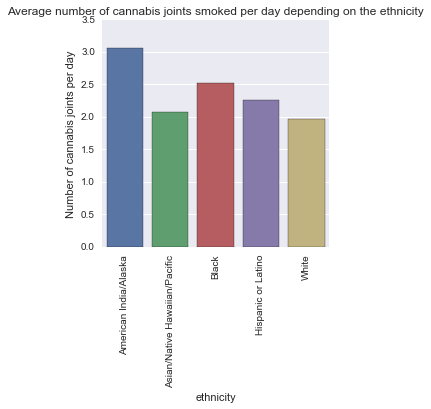

In [11]:
g = sns.factorplot(x='ethnicity', y='nb_joints_day', data=subnesarc, 
                   kind="bar", ci=None)
g.set_xticklabels(rotation=90)
plt.ylabel('Number of cannabis joints per day')
_ = plt.title('Average number of cannabis joints smoked per day depending on the ethnicity')

The null hypothesis is *There is no relationship between the number of joints smoked per day and the ethnicity*.

The alternate hypothesis is *There is a relationship between the number of joints smoked per day and the ethnicity*.

In [12]:
model2 = smf.ols(formula='nb_joints_day ~ C(ethnicity)', data=subnesarc).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          nb_joints_day   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     11.34
Date:                Sat, 21 May 2016   Prob (F-statistic):           3.55e-09
Time:                        15:53:34   Log-Likelihood:                -21101.
No. Observations:                7967   AIC:                         4.221e+04
Df Residuals:                    7962   BIC:                         4.225e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------------------
Intercept                                         3.0571      0.236     12.950      0.000         2.594     3.520
C(ethnicity)[T.Asian/Native Hawaiian/Pacific]    -0.9914      0.376     -2.639      0.008        -1.728    -0.255
C(ethnicity)[T.Black]                            -0.5424      0.255     -2.127      0.033        -1.042    -0.042
C(ethnicity)[T.Hispanic or Latino]               -0.7997      0.257     -3.113      0.002        -1.303    -0.296
C(ethnicity)[T.White]                            -1.0943      0.241     -4.545      0.000        -1.566    -0.622
==============================================================================
Omnibus:                    13078.464   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14564258.345
Skew:                          10.756   Prob(JB):                         0.00
Kurtosis:                     211.353   Cond. No.                         17.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value is much smaller than 5%. Therefore the null hypothesis is rejected. We can now look at which group are really different from the other.

In [13]:
import statsmodels.stats.multicomp as multi

multi1 = multi.MultiComparison(subnesarc['nb_joints_day'], subnesarc['ethnicity'])
result1 = multi1.tukeyhsd()
result1.summary()

group1,group2,meandiff,lower,upper,reject
American India/Alaska,Asian/Native Hawaiian/Pacific,-0.9914,-2.0165,0.0336,False
American India/Alaska,Black,-0.5424,-1.2383,0.1535,False
American India/Alaska,Hispanic or Latino,-0.7997,-1.5005,-0.0989,True
American India/Alaska,White,-1.0943,-1.7512,-0.4374,True
Asian/Native Hawaiian/Pacific,Black,0.449,-0.3908,1.2889,False
Asian/Native Hawaiian/Pacific,Hispanic or Latino,0.1917,-0.6522,1.0357,False
Asian/Native Hawaiian/Pacific,White,-0.1028,-0.9107,0.705,False
Black,Hispanic or Latino,-0.2573,-0.639,0.1244,False
Black,White,-0.5519,-0.8453,-0.2585,True
Hispanic or Latino,White,-0.2946,-0.5995,0.0103,False


From the Tukey's Honestly Significant Difference Test, we can conclude there are 3 relationship presenting a real difference:

- American India/Alaska group smokes more than the Hispanic or Latino group
- American India/Alaska group smokes more than the White group
- Black group smokes more than White group

## Summary

Using the ANOVA test on the research question *do countries with a high internet use rate have a higher number of suicides?* brought me to the conclusion that there is no relationship between the internet use rate and the number of suicide.

So in order to fulfill this assignment, I switch to the NESARC database. My interest focus on a possible relationship between ethnicity and the number of cannabis joints smoked per day. After verifying that there is a significant relationship, I applied the Tukey HSD method to figure out which groups were really different one from the other. 

There are 3 relationship presenting a real difference:

- American India/Alaska group smokes more than the Hispanic or Latino group
- American India/Alaska group smokes more than the White group
- Black group smokes more than White group



> If you are interested data sciences, follow me on [Tumblr](http://fcollonval.tumblr.com/).